# Development - Pasiphae survey: strategy

This notebook is not primarily a demonstration of the survey strategy, but follows through the steps of developing and implementing the survey strategy.

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
from astropy.coordinates import AltAz, Angle, EarthLocation, get_sun, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
import cmasher as cmr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import sqlite3

import constraints as c
from db import DBConnectorSQLite
from skyfields import Field, SkyFields
from surveyplanner import ObsWindow, Telescope, SurveyPlanner

## Outline of the survey strategy

1. The sky is divided into fields. The field size is dictated by the instruments field-of-view (FoV). WALOP-N and -S will have different FoV. Thus, the field grid will differ in the northern and southern hemisphere. As a consequence, fields are tied to 1. specific instrument. The field grid is developed in the notebook `SkyFields.ipynb`.
1. The survey strategy defines how fields are selected for observations.
    1. We use two main prioritization schemes:
        1. Coherence in sky coverage: select field close to other fields already done.
        1. Source observability: select fields that are not available for long.
    1. We will apply a weighting between the two schemes.
1. A database is used to store the fields, their observability, and observation status as well as all other information required for the survey planning.

In this notebook we develop the different parts of the survey strategy. Note that we do not use the actual Pasiphae field grid, but a very coarse grid to reduce the computing time.

## Create test grid

In [12]:
# north:
fov = np.radians(10.)
overlap = np.radians(2.)
tilt = np.radians(0.)
b_lim = np.radians(30.)
dec_lim_south = np.radians(-10.)

fields_north = SkyFields(fov, overlap, tilt=tilt, b_lim=b_lim, dec_lim_south=dec_lim_south)
print('\n', fields_north)

Creating fields..
Done.                              

 SkyFields
Field of view:    10.0000 deg
Overlap            2.0000 deg
Tilt:             +0.0000 deg
Gal. lat. lim:    30.0000 deg
Dec. lim. N:      None
Dec. lim. S:      -10.0000 deg
Number of fields: 194


In [13]:
# south:
fov = np.radians(12.)
overlap = np.radians(2.)
tilt = np.radians(0.)
b_lim = np.radians(30.)
dec_lim_north = np.radians(10.)

fields_south = SkyFields(fov, overlap, tilt=tilt, b_lim=b_lim, dec_lim_north=dec_lim_north)
print('\n', fields_south)

Creating fields..
Done.                              

 SkyFields
Field of view:    12.0000 deg
Overlap            2.0000 deg
Tilt:             +0.0000 deg
Gal. lat. lim:    30.0000 deg
Dec. lim. N:      10.0000 deg
Dec. lim. S:      None
Number of fields: 100


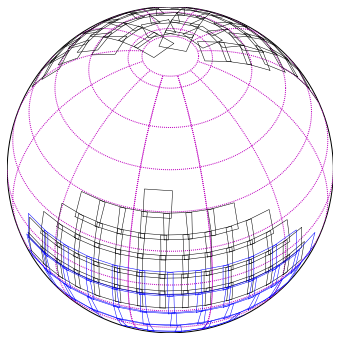

In [14]:
fig = plt.figure(figsize=(6, 6))
m = Basemap(projection='ortho',lon_0=15,lat_0=45,resolution='l')
m.drawparallels(np.arange(-90.,120.,15.),color='m',alpha=0.5)
m.drawmeridians(np.arange(0.,420.,30.),color='m',alpha=0.5)

for field in fields_north.get_fields():
    corners_ra = field.corners_coord.ra.deg
    corners_ra = np.r_[corners_ra, corners_ra[0]]
    corners_dec = field.corners_coord.dec.deg
    corners_dec = np.r_[corners_dec, corners_dec[0]]
    m.plot(corners_ra, corners_dec, color='k', linestyle='-', linewidth=0.5, latlon=True)


for field in fields_south.get_fields():
    corners_ra = field.corners_coord.ra.deg
    corners_ra = np.r_[corners_ra, corners_ra[0]]
    corners_dec = field.corners_coord.dec.deg
    corners_dec = np.r_[corners_dec, corners_dec[0]]
    m.plot(corners_ra, corners_dec, color='b', linestyle='-', linewidth=0.5, latlon=True)

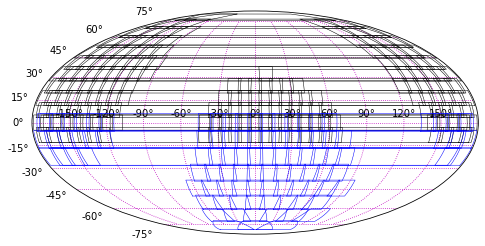

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True, color='m', linestyle=':')

for field in fields_north.get_fields():
    corners_ra = field.corners_coord.ra.rad
    corners_ra = np.r_[corners_ra, corners_ra[0]]
    corners_ra = np.where(corners_ra > np.pi, corners_ra - 2*np.pi, corners_ra)
    corners_dec = field.corners_coord.dec.rad
    corners_dec = np.r_[corners_dec, corners_dec[0]]
    ax.plot(corners_ra, corners_dec, color='k', linestyle='-', linewidth=0.5)

for field in fields_south.get_fields():
    corners_ra = field.corners_coord.ra.rad
    corners_ra = np.r_[corners_ra, corners_ra[0]]
    corners_ra = np.where(corners_ra > np.pi, corners_ra - 2*np.pi, corners_ra)
    corners_dec = field.corners_coord.dec.rad
    corners_dec = np.r_[corners_dec, corners_dec[0]]
    ax.plot(corners_ra, corners_dec, color='b', linestyle='-', linewidth=0.5)

## Database 

### Database schema

**Note:** The goal is to base the Pasiphae survey planner / observation planner on the TOM-toolkit. For development of the survey planner I find it easier to work with a simple data base structure rather than figuring out the database and code implementation of the TOM-toolkit first. Therefore, I will use my own database schema for the concept development.


#### Observatories

The `Observatories` table contains the basic information about the observatories.

| table Observatories | | |
|---|---|---|
| observatory_id | int | Unique identifier |
| lat | float | Latitude in rad |
| lon | float | Longitude in rad |
| heigth | float | Height in meters |
| utc_offset | float | UTC_offset during normal time |


#### Parameter sets, constraints, and parameters

Observation windows (time periods when a source is observable) need to be calculated for a specific set of constraints. Those can be (i) the technical constraints specific for a telescope like hourangle limits, (b) observational constraints like separtion from the Moon and airmass limit, as well as (c) the definition of night start, e.g. astronomical twilight. If we change anything for such a set, precalculated `ObsWindows` are not applicable anymore. Therefore, ObsWindows need to be tied to a set of constraints. Therefore, we need to store those sets, the related constraints, and the parameters for those constraints in the database.

The `ParameterSet` table contains parameter sets. A set is a complete compilation of all constraints applied to calculate the observation windows. A set is tied to one observatory. A set cannot be changed. Only one set per observatory can be the active set.

| table ParameterSet | | |
|---|---|---|
| parameter_set_id | int | Unique identifier |
| observatory_id | int | ID of the related observatory |
| active | bool | Only the active parameter set is used |
| date | datetime | Date when the parameter set was added |

The `Constraints` table lists all constraints. This table relates the parameters to the specific constraint class. All constraint classes defined in the `constraints.py` module need to be defined in the database and the `constraint_name` in the database must match that of the corresponding constraint in `constraints.py`. **Note:** This is a critical point, because any changes made in `constraints.py` need to be implemented in the database interface as well. **Second note:** The definition of the used twilight is a constaint on the observations, but not a Constraint class; nevertheless it will be added to this table. Whereas constraints are optional (even though in reality every observatory will have some constraints), the definition of twilight will be a necessary constraint in the context of the Pasiphase survey. (For radio telescopes this would not be the case, but we are not developing a general use target and observation manager.)

| table Constraints | | |
|---|---|---|
| constraint_id | int | Unique identifier |
| constraint_name | char | Name of the observational constraint |

The `Parameters` table contains all parameters associated with added constraints. A constraint may require multiple parameters. Therefore, the `parameter_name` needs to match the corresponding argument of the class initialization. **Note:** Through the use of argument names instead of argument positions the relation between the `constraints.py` module and the database is less error prone, because changes in the order of arguments will not result in errors.

| table Parameters | | |
|---|---|---|
| parameter_id | int | Unique identifier |
| constraint_id | int | ID of the associated constraint |
| parameter_set_id | int | ID of the associated parameter set |
| parameter_name_id | int | ID of the corresponding argument name in the associated class initialization |
| value | float | Numerical value |
| svalue | char | String value |

To avoid many dublications of parameter names in the above table, parameter names will be defined in the `ParameterNames` table and referenced through an ID.

| table ParameterNames | | |
|---|---|---|
| parameter_name_id | int | Unique identifier |
| parameter_name | char | Parameter name corresponding to argument name in the associated class initialization |


#### Fields

The `Fields` table contains the main information about fields. A field is directly associated with an observatory. WALOP North and South will have different field-of-view and, thus, will require different sky grids, even in the overlapping region. Therefore, a field will be related to one specific observatory. The `active` column will state whether a field should be scheduled or not. If we want to discard fields we can set them inactive rather than deleting those entries. The `jd_next_obs_window` column stores the latest JD up to which observation windows have been calculated. For sources with seasonal availability the latest stored observation window may not be on the latest date for which the windows were calculated. To avoid calculating windows over and over again for dates when the source is not available it is necessary to store the date for which the latest calculation was done.

| table Fields | | |
|---|---|---|
| field_id | int | Unique identifier |
| fov | Field of view in rad |
| center_ra | float | Right ascension in rad |
| center_dec | float | Declination in rad |
| tilt | Field tilt in rad |
| observatory_id | int | ID of associated observatory |
| active | bool | Only active fields will be scheduled |
|jd_next_obs_window | float | JD of the latest caculated obs window |


#### Observation windows

The `ObsWindows` table contains the information when fields are observable. The calculation of ObsWindows is described above. **Note:** ObsWindows relate to a specific field and through that to a specific observatory. However, they also depend on the specified set of constraints. If the constraints are changed, ObsWindows need to be recalculated. Former ObsWindows need to be set inactive and must not be used in the survey/observation planning.

| table ObsWindows | | |
|---|---|---|
| obswindow_id | int | Unique identifier |
| field_id | int | ID of the assiciated field |
| date_start | datetime | Date and time when the field becomes observable |
| date_stop | datetime | Date and time when the field stops to be observable |
| duration | float | Duration of the observable window in hours |
| active | bool | Only active ObsWindows will be taken into consideration |

#### Observations and reductions

The `Observations` table lists observations of fields. Fields that have been observered should not be scheduled again. **Note:** For some reasons we may need to revisit fields, e.g. if the quality was poor. I need to implement a way to allow for rescheduling of observed fields.

| table Observations | | |
|---|---|---|
| observation_id | int | Unique identifier |
| field_id | int | ID of the observed field |
| date | datetime | Date and time of the observation |

The `Reductions` table lists which fields have been reduced. **Note:** This will be of interest to visualize the survey progress. For the current development of the survey planner it is not relevant. Therefore, I will not include it in the database yet.

| table Reductions | | |
|---|---|---|
| reduction_id | int | Unique identifier |
| field_id | int | ID of the associated field |
| reduction_date | datetime | Date and time of the reduction |

### Database interface

#### Create data base

In [216]:
db = DBConnectorSQLite('test.sqlite3')
db.create_db()

Database file exists. Overwrite (y) or cancel (enter)? y


Database 'test.sqlite3' created.
Table 'Fields' created.
Table 'Observatories' created.
Table 'ParameterSet' created.
Table 'Constraints' created.
Table 'Parameters' created.
Table 'ParameterNames' created.
Table 'ObsWindows' created.
Table 'Observations' created.
Constraints added to table 'Constraints'.


#### Add and query telescopes

In [217]:
name = 'Skinakas'
lat = Angle('35:12:43 deg')
lon = Angle('24:53:57 deg')
height = 1750.
utc_offset = 2.
db.add_observatory(name, lat.rad, lon.rad, height, utc_offset)

Observatory 'Skinakas' added.


In [218]:
name = 'Sutherland'
lat = Angle('32:22:46 deg')
lon = Angle('20:48:38.5 deg')
height = 1798.
utc_offset = 2.
db.add_observatory(name, lat.rad, lon.rad, height, utc_offset)

Observatory 'Sutherland' added.


Get observatory from data base by name:

In [219]:
telescope = db.get_observatory('Skinakas')
print('\n', telescope, sep='')


{'telescope_id': 1, 'name': 'Skinakas', 'lat': <Quantity 0.61456437 rad>, 'lon': <Quantity 0.43457244 rad>, 'height': 1750.0, 'utc_offset': 2.0}


#### Add and query constraints

Add constraints for each observatory:

In [220]:
twilight = 'nautical'
airmass_limit = c.AirmassLimit(2.)
moon_distance = c.MoonDistance(10.)

db.add_constraints('Skinakas', twilight, constraints=(airmass_limit, moon_distance))
db.add_constraints('Sutherland', twilight, constraints=(airmass_limit, moon_distance))

Get currently active constraints and corresponding parameters for one observatory:

In [221]:
db.get_constraints('Skinakas')

{'Twilight': {'twilight': -12.0},
 'AirmassLimit': {'limit': 2.0, 'conversion': 'secz'},
 'MoonDistance': {'limit': 10.0}}

#### Add and query fields

Add fields for Skinakas telescope:

In [222]:
db.add_fields(fields_north, 'Skinakas', active=True)

194 fields added to database.                   


Add fields for Sutherland telescope:

In [223]:
db.add_fields(fields_south, 'Sutherland', active=True)

100 fields added to database.                   


Get all fields:

In [224]:
fields = db.get_fields(active=True)
print('Number of fields:', len(fields))

Number of fields: 294


Get fields for specified observatory:

In [225]:
fields = db.get_fields(observatory='Skinakas', active=True)
print('Number of fields:', len(fields))

Number of fields: 194


**Note:** The database interface comprises more features than described above. These features are closely tied to the following parts of development and are therefore explained in the following.

## Field availability

For the source observability we need to know:

1. For how many nights is the target observable during a year?
1. At a given date for how many nights will the target remain observable?
1. For how long is a target observable at a given night? (do we really need this?)

Targets that will not be available anymore soon and targets that are generally only observable for a short period of time should be prioratized.

For that we need to calculate, when targets are observable. In the following we will call a period of time during which a target is continuously observable *observing window*. We will calulate the obs. windows for all targets for each night and for a certain time into the future. The obs. windows will be stored in the data base. The reason is that those calculations are time intensive and will be needed again by the observation planner. Rather than re-calculating obs. windows, we will store them once calculated.

**Note:** The following sections [4.1](#setup_tel) and [4.2](#obs_window_field) are a demonstration how the obs window calculation is done for a specific field during one night. These procedures are implemented in `surveyplanner.py` and the calculation through the surveyplanner module is demonstrated in section [4.3](#obs_window_fields).

<a id='setup_tel'></a>
### Set up telescope and constaints

Read telescope details from database and create `Telescope` instance:

In [226]:
db = DBConnectorSQLite('test.sqlite3')

In [227]:
telescope = db.get_observatory('Skinakas')
telescope = Telescope(
        telescope['lat'], telescope['lon'], telescope['height'], telescope['utc_offset'], name=telescope['name'])
print(telescope)

Telescope: Skinakas created.
Telescope 
Name: Skinakas
Lat:     +35.2119 deg
Lon:      24.8992 deg
Height:   1750.00 m
UTC offset:  2.00 hours



Read constraints from database:

In [228]:
constraints = db.get_constraints('Skinakas')
print(constraints)

{'Twilight': {'twilight': -12.0}, 'AirmassLimit': {'limit': 2.0, 'conversion': 'secz'}, 'MoonDistance': {'limit': 10.0}}


Read the twilight definition (i.e. Sun declination at which the night 'starts') from the `constraints`-dictionary:

In [229]:
twilight = constraints['Twilight']['twilight']
print(twilight)

-12.0


Remove the `'Twilight'` entry from the dictionary. All remaining entries are telescope specific observational constraints:

In [230]:
del constraints['Twilight']

(1) Parse the constraints names, parameter names, and parameter values into executable code, (2) create the corresponding constraint class instances, and (3) add them to the `telescope`-instance:

In [231]:
for constraint_name, params in constraints.items():
    
    # parse constraint code:
    text = f"c.{constraint_name}("
    
    for arg, val in params.items():
        if isinstance(val, str):
            text += f"{arg}='{val}', "
        else:
            text += f"{arg}={val}, "
    
    if text[-1] == "(":
        text += ")"
    else:
        text = f"{text[:-2]})"
    
    print(text)
    
    # evaluate code and add constraint to telescope:
    constraint = eval(text)
    telescope.add_constraint(constraint)

c.AirmassLimit(limit=2.0, conversion='secz')
Constraint added: Airmass limit: 2.00
c.MoonDistance(limit=10.0)
Constraint added: Moon distance: 10.00 deg


<a id='obs_window_field'></a>
### Calculate observing windows for a field

In [232]:
time_sunset, time_sunrise = telescope.get_sun_set_rise(2022, 4, 1, twilight)
night_duration = time_sunrise - time_sunset
print(time_sunset + telescope.utc_offset)
print(time_sunrise + telescope.utc_offset)
print(night_duration.to(u.hour))

2022-04-01T19:37:20.257
2022-04-02T05:10:28.663
9.552334993241267 h


Create time steps between Sun set and rise and create `AltAz`-frame for the telescope:

In [233]:
time_interval = 10. * u.min
frame = telescope.get_frame(time_sunset, time_sunrise, time_interval)

Calculate obs. window for one field. The result is given as a tuple of `Time` objects giving the times when the field starts and stops to be observable. We can convert the tuple to an `ObsWindow` object:

In [234]:
fields = db.get_fields(observatory='Skinakas')
field = fields[10]
fov = field[1]
center_ra = field[2]
center_dec = field[3]
tilt = field[4]
field_id = field[6]
field = Field(fov, center_ra, center_dec, tilt, field_id=field_id)
obs_window = field.get_obs_window(telescope, frame, refine=1*u.min)[0]
obs_window = ObsWindow(*obs_window)
print(obs_window)

ObsWindow
Start: 2022-04-01T17:37:20.257
Stop:  2022-04-01T22:57:20.257
Duration: 5.33 h


Test another field:

In [235]:
fields = db.get_fields(observatory='Skinakas')
field = fields[20]
fov = field[1]
center_ra = field[2]
center_dec = field[3]
tilt = field[4]
field_id = field[6]
field = Field(fov, center_ra, center_dec, tilt, field_id=field_id)
obs_window = field.get_obs_window(telescope, frame, refine=1*u.min)[0]
obs_window = ObsWindow(*obs_window)
print(obs_window)

ObsWindow
Start: 2022-04-01T22:34:20.257
Stop:  2022-04-02T03:16:20.257
Duration: 4.70 h


<a id="obs_window_fields"></a>
### Calculate observing windows for all fields

At this stage we introduce the `SurveyPlanner` class, which implements the overall survey strategy. The strategy and its implementation is discussed in section [5](#survey_strategy). Here, we first calculate observing windows for all fields stored in the database. Those observing windows are then automatically stored in the database.

We start by creating a `SurveyPlanner` instance, accessing the database we created above:

In [236]:
surveyplanner = SurveyPlanner('test.sqlite3')

The `add_obs_windows()` methods is used to calculate and add observing windows for all fields. The required first argument of the method is the date until which daily observation windows should be calculated. It needs to be given as `astropy.time.Time` object. The optional argument `date_start` also requires an `astropy.time.Time` object and sets the date from which on observing windows will be calculated. If no start date is provided, the current date will automatically be used as start date.

Unless the database has only been initialized, each field will have a JD stored that saves up to which JD (00:00:00 UTC) observing windows have already been calculated. There are various options that will be checked for each field separately:

1. If the stop date is earlier than the stored date and/or the start date, the field is simply skipped.
1. If the start date is earlier than the stored date, the observing window calculation will start with the stored date.
1. If the start date is later than the stored date, the user will be asked whether or not to continue. If not, the method is aborted entirely and no observing windows will be calculated and stored. If yes, observing windows will be calculate from the start date onwards. This implies that there will be a gap in stored observing windows. The time between the latest stored JD and the new start date will not be covered.
1. Otherwise, observing windows will be calculated between the last stored date and the stop date.

<div class="alert alert-block alert-warning">
<b>TODO:</b> Add description..
</div>

In [238]:
surveyplanner.add_obs_windows(Time('2022-04-18'))
#surveyplanner.add_obs_windows(Time('2022-04-16'), date_start=Time('2022-04-15'))

Calculate observing windows until 2022-04-18 00:00:00.000..
Observatory 1 of 2 selected: Skinakas
Telescope: Skinakas created.
Constraint added: Airmass limit: 2.00
Constraint added: Moon distance: 10.00 deg
Field 194 of 194 (100%)...
Observatory 2 of 2 selected: Sutherland
Telescope: Sutherland created.
Constraint added: Airmass limit: 2.00
Constraint added: Moon distance: 10.00 deg
Field 100 of 100 (100%)...
Calculating observing windows done.


#### Select fields available at given time

#### Select fields available during given night

### Visualizations of field availability

<div class="alert alert-block alert-warning">
<b>TODO:</b> Add some visualizations of the results.
</div>

In [111]:
n_fields = len(fields_north)
field_duration = np.zeros(n_fields)

for i, field in enumerate(fields_north.fields):
    print(f'\rField {i} of {n_fields}', end='')
    for obs_window in field.get_obs_window(telescope, frame, refine=1*u.min):
        field_duration[i] += obs_window.duration.value

print('\rDone.             ')

Done.             


In [14]:
observability_fraction = field_duration / night_duration.value

In [15]:
cmap = cmr.ember

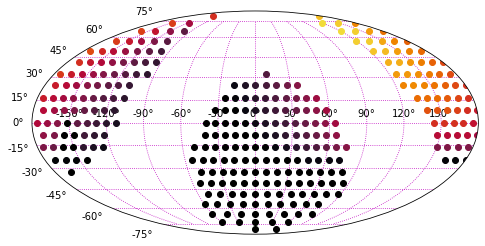

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True, color='m', linestyle=':')

for i, field in enumerate(fields.get_fields()):
    center_ra = field.center_coord.ra.rad
    center_ra = np.where(center_ra > np.pi, center_ra - 2*np.pi, center_ra)
    center_dec = field.center_coord.dec.rad
    ax.plot(center_ra, center_dec, marker='o', color=cmap(observability_fraction[i]))

In [17]:
print('{0:.2f} hours'.format(field_duration.max() * 24.))
print('  {0:.0f} %'.format(field_duration.max() / night_duration.value * 100.))

11.67 hours
  99 %


In [18]:
time_sunset, time_sunrise = telescope.get_sun_set_rise(2022, 1, 31, 'nautical')
night_duration = time_sunrise - time_sunset
print(time_sunset + telescope.utc_offset)
print(time_sunrise + telescope.utc_offset)
print(night_duration.to(u.hour))

2022-01-31T18:44:39.506
2022-02-01T06:22:41.853
11.63398543397935 h


In [19]:
time_interval = 10. * u.min
frame = telescope.get_frame(time_sunset, time_sunrise, time_interval)

In [20]:
n_fields = len(fields)
field_duration1 = np.zeros(n_fields)

for i, field in enumerate(fields.fields):
    print(f'\rField {i} of {n_fields}', end='')
    for obs_window in field.get_obs_window(telescope, frame, refine=1*u.min):
        field_duration1[i] += obs_window.duration.value

print('\rDone.             ')

Done.             


In [21]:
field_reducing_obs = np.where(field_duration > field_duration1, 0.8, 0.2)

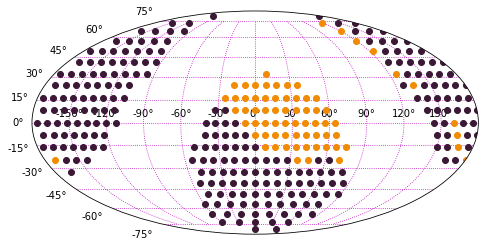

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True, color='m', linestyle=':')

for i, field in enumerate(fields.get_fields()):
    center_ra = field.center_coord.ra.rad
    center_ra = np.where(center_ra > np.pi, center_ra - 2*np.pi, center_ra)
    center_dec = field.center_coord.dec.rad
    ax.plot(center_ra, center_dec, marker='o', color=cmap(field_reducing_obs[i]))

<a id="survey_strategy"></a>
## Survey strategy